In [23]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("bhavikjikadara/dog-and-cat-classification-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/dog-and-cat-classification-dataset


In [24]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from tensorflow import keras
from keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.preprocessing import image_dataset_from_directory

import os
import matplotlib.image as mpimg
import imghdr # Import imghdr to check image types

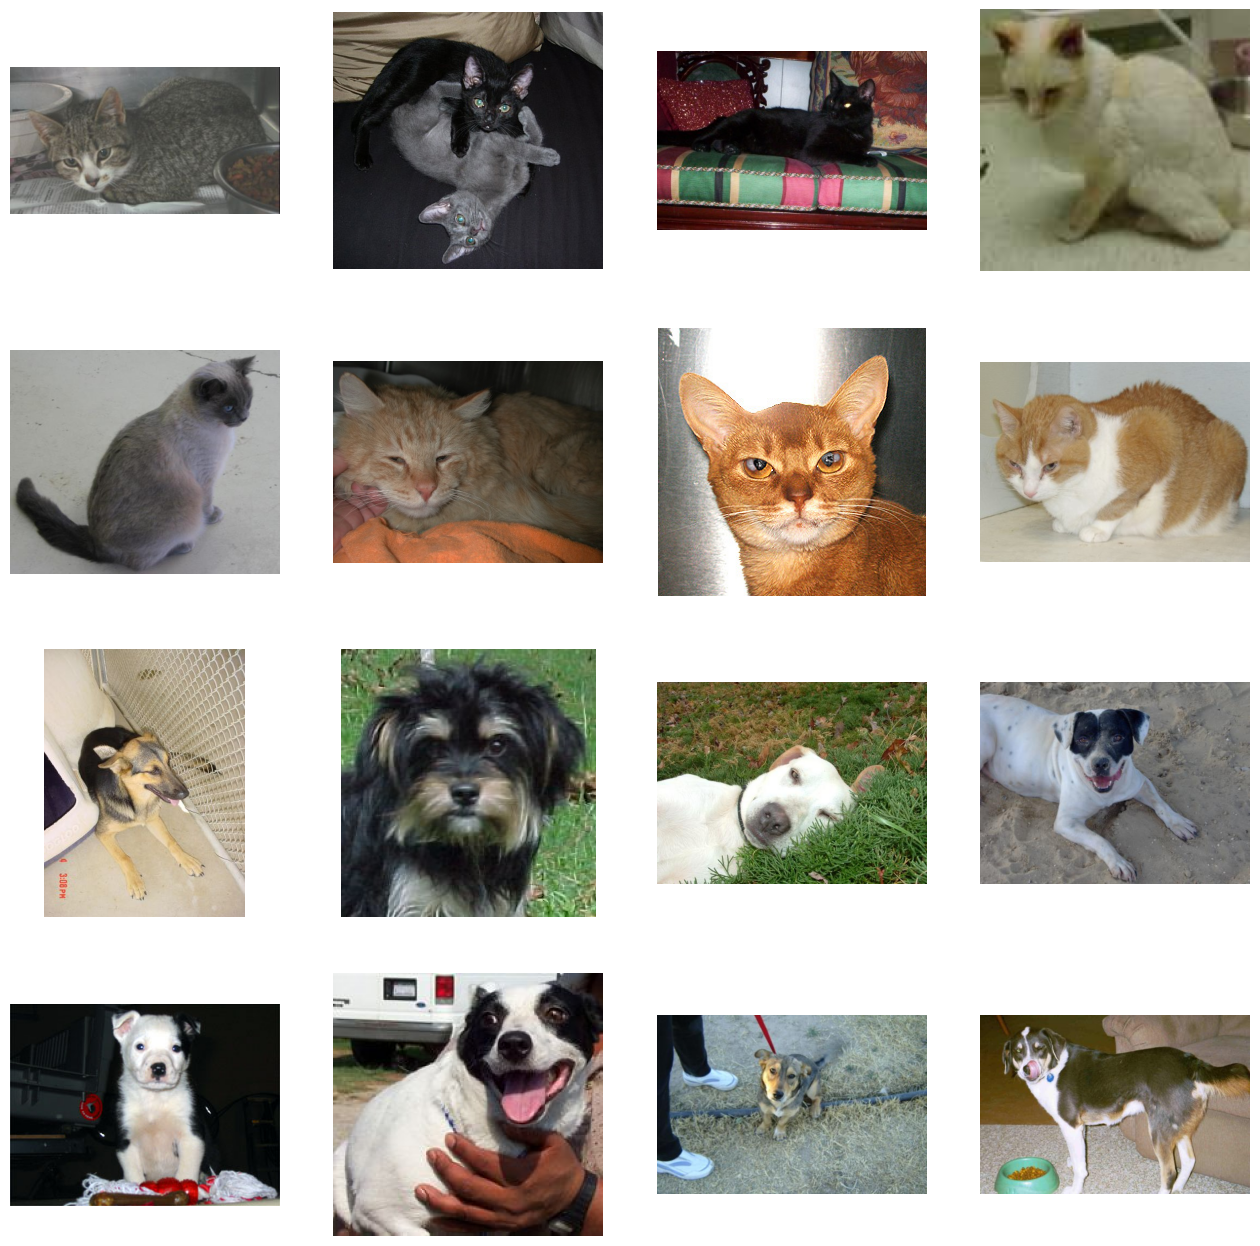

In [25]:
fig = plt.gcf()
fig.set_size_inches(16, 16)

cat_dir = os.path.join('/root/.cache/kagglehub/datasets/bhavikjikadara/dog-and-cat-classification-dataset/versions/1/PetImages/Cat')
dog_dir = os.path.join('/root/.cache/kagglehub/datasets/bhavikjikadara/dog-and-cat-classification-dataset/versions/1/PetImages/Dog')
cat_names = os.listdir(cat_dir)
dog_names = os.listdir(dog_dir)

pic_index = 210

cat_images = [os.path.join(cat_dir, fname)
              for fname in cat_names[pic_index-8:pic_index]]
dog_images = [os.path.join(dog_dir, fname)
              for fname in dog_names[pic_index-8:pic_index]]

for i, img_path in enumerate(cat_images + dog_images):
    sp = plt.subplot(4, 4, i+1)
    sp.axis('Off')

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

In [26]:
# Define the base directory
base_dir = '/root/.cache/kagglehub/datasets/bhavikjikadara/dog-and-cat-classification-dataset/versions/1/PetImages'

# Function to check if a file is a valid image (specifically focusing on potential issues with JPEGs)
def is_valid_image(file_path):
    try:
        # Try to read the image with TensorFlow's file reader
        tf.io.read_file(file_path)
        # Additional check using imghdr
        if imghdr.what(file_path) in ['jpeg', 'png']: # Consider adding other formats if necessary
             return True
        else:
            print(f"Skipping non-image file: {file_path}")
            return False
    except Exception as e:
        print(f"Skipping corrupted or invalid file: {file_path} - {e}")
        return False

In [27]:
# Create lists of valid image paths
cat_dir = os.path.join(base_dir, 'Cat')
dog_dir = os.path.join(base_dir, 'Dog')

cat_image_paths = [os.path.join(cat_dir, fname) for fname in os.listdir(cat_dir) if is_valid_image(os.path.join(cat_dir, fname))]
dog_image_paths = [os.path.join(dog_dir, fname) for fname in os.listdir(dog_dir) if is_valid_image(os.path.join(dog_dir, fname))]

Skipping non-image file: /root/.cache/kagglehub/datasets/bhavikjikadara/dog-and-cat-classification-dataset/versions/1/PetImages/Cat/6906.jpg
Skipping non-image file: /root/.cache/kagglehub/datasets/bhavikjikadara/dog-and-cat-classification-dataset/versions/1/PetImages/Cat/2569.jpg
Skipping non-image file: /root/.cache/kagglehub/datasets/bhavikjikadara/dog-and-cat-classification-dataset/versions/1/PetImages/Cat/2742.jpg
Skipping non-image file: /root/.cache/kagglehub/datasets/bhavikjikadara/dog-and-cat-classification-dataset/versions/1/PetImages/Cat/8295.jpg
Skipping non-image file: /root/.cache/kagglehub/datasets/bhavikjikadara/dog-and-cat-classification-dataset/versions/1/PetImages/Cat/6768.jpg
Skipping non-image file: /root/.cache/kagglehub/datasets/bhavikjikadara/dog-and-cat-classification-dataset/versions/1/PetImages/Cat/6435.jpg
Skipping non-image file: /root/.cache/kagglehub/datasets/bhavikjikadara/dog-and-cat-classification-dataset/versions/1/PetImages/Cat/9361.jpg
Skipping non-

In [28]:
# Combine the lists and create labels
all_image_paths = cat_image_paths + dog_image_paths
labels = [0] * len(cat_image_paths) + [1] * len(dog_image_paths) # 0 for cat, 1 for dog

# Convert to TensorFlow dataset
dataset = tf.data.Dataset.from_tensor_slices((all_image_paths, labels))

# Function to load and preprocess images
def load_and_preprocess_image(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3) # Assuming JPEG, adjust if other formats are present
    img = tf.image.resize(img, [200, 200])
    img = tf.image.convert_image_dtype(img, dtype=tf.float32) # Normalize to [0, 1]
    return img, label

dataset = dataset.map(load_and_preprocess_image).shuffle(buffer_size=1000)

# Split into training and validation datasets
validation_split = 0.1
dataset_size = tf.data.experimental.cardinality(dataset).numpy()
train_size = int((1 - validation_split) * dataset_size)

train_datagen = dataset.take(train_size).batch(32)
test_datagen = dataset.skip(train_size).batch(32)

In [29]:
model = tf.keras.models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.1),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 198, 198, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 99, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 97, 97, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 46, 46, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 21, 21, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │     3,277,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,902,529 (14.89 MB)

 Trainable params: 3,899,457 (14.88 MB)

 Non-trainable params: 3,072 (12.00 KB)

In [ ]:
model.compile( loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(train_datagen, epochs=10, validation_data=test_datagen)

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
plt.show()

In [ ]:
def predict_image(image_path):
    img = image.load_img(image_path, target_size=(200, 200))
    plt.imshow(img)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)

    result = model.predict(img)
    print("Dog" if result >= 0.5 else "Cat")

predict_image('/root/.cache/kagglehub/datasets/bhavikjikadara/dog-and-cat-classification-dataset/versions/1/PetImages/Cat/10.jpg')
predict_image('/root/.cache/kagglehub/datasets/bhavikjikadara/dog-and-cat-classification-dataset/versions/1/PetImages/Dog/10.jpg')